**x output nodes 2pi batch 250 100000 samples 235**



We try to solve the simpler problem of auto-encoding the frequency of a sine wave. The function is 

$$ A \sin(fx) $$

where $x_{in} \in$ [0, 2$\pi$] and $x_{out} \in$ [0, 2$\pi$]. We have for the frequency $f \in [2, 3.5]$ and for the amplitude $A \in [1, 3]$.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

path = "/content/drive/My Drive/PhD year 1/BETA playground Af/"

Mounted at /content/drive


# Setting up data

Shape f_0: (100000,)
Shape A_0: (100000,)
Shape x_meas: (100000, 2)
Shape y_out: (100000, 2)
Frequency: f = 3.730
Amplitude: A = 3.590
x_meas: [5.0025786  4.75823628]
y_out: [-0.67662762 -3.20129031]
Frequency: f = 2.399
Amplitude: A = 3.391
x_meas: [1.38966088 1.85240101]
y_out: [-0.64909512 -3.2700065 ]


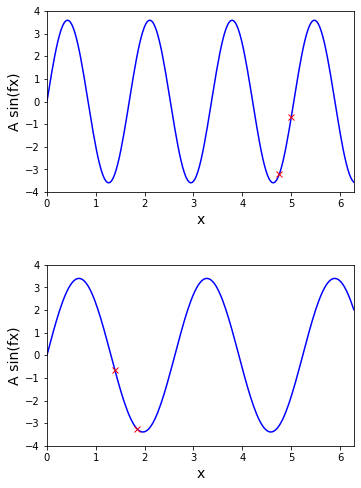

In [2]:
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
plt.style.use('default')
import random
%matplotlib inline
# Creating data of sin(fx), 100000 samples
f_interval = [0.8 * 2, 1.2 * 3.5]
f_0 = (f_interval[1] - f_interval[0]) * np.random.rand(100000) + f_interval[0]
A_interval = [0.8 * 1, 1.2 * 3]
A_0 = (A_interval[1] - A_interval[0]) * np.random.rand(100000) + A_interval[0]
x_sample = np.linspace(0, 2*np.pi, 200)
y_in = np.array([A * np.sin(f * x_sample) for f, A in zip(f_0, A_0)])

x_meas_interval = [0, 2*np.pi]

def make_data(OUTPUT_NODES):

  # Create question
  x_meas = np.reshape(np.random.rand(100000*OUTPUT_NODES) * (x_meas_interval[1] - x_meas_interval[0]) + x_meas_interval[0], [100000, OUTPUT_NODES])

  # Create answer
  y_out = np.multiply(A_0.reshape(-1, 1), np.sin(np.multiply(f_0.reshape(-1, 1), x_meas))).reshape(100000, OUTPUT_NODES) # list comprehension very slow

  return x_meas, y_out

OUTPUT_NODES = 2
x_meas, y_out = make_data(OUTPUT_NODES=OUTPUT_NODES)

print(f"Shape f_0: {f_0.shape}")
print(f"Shape A_0: {A_0.shape}")
print(f"Shape x_meas: {x_meas.shape}")
print(f"Shape y_out: {y_out.shape}")

sample_idx_list = [98000, 98001]

plt.figure(figsize=(5.5, 8)) # 11,4
for i, sample_idx in enumerate(sample_idx_list):
  print(f"Frequency: f = {f_0[sample_idx]:.03f}")
  print(f"Amplitude: A = {A_0[sample_idx]:.03f}")
  plt.subplot(2, 1, i+1)
  plt.plot(x_sample, y_in[sample_idx], 'b');
  plt.plot(x_meas[sample_idx], y_out[sample_idx], 'rx')
  plt.xlabel('x', fontsize=14);
  plt.ylabel('A sin(fx)', fontsize=14);
  plt.xlim([0, 2*np.pi]);
  plt.ylim([-4, 4])
  print(f"x_meas: {x_meas[sample_idx]}")
  print(f"y_out: {y_out[sample_idx]}")
#plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.4)
plt.show()

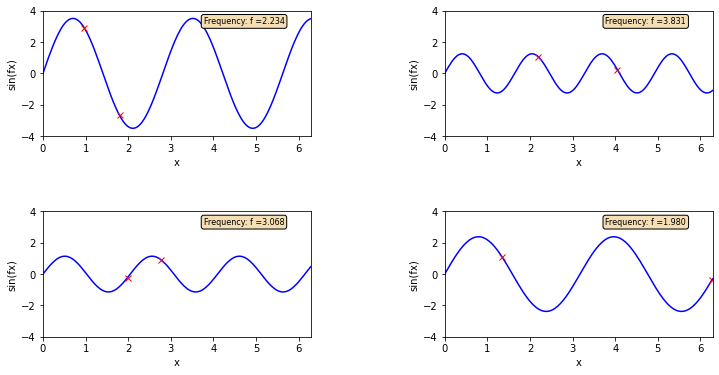

In [3]:
# Plot 4 samples of the training data
def plot_training_data(sample_idx_list):

  fig = plt.figure(figsize=(12, 6))
  plt.subplots_adjust(hspace=0.6, wspace=0.5)

  for i, sample_idx in enumerate(sample_idx_list):
    ax = plt.subplot(2, 2, i+1)
    
    plt.plot(x_sample, y_in[sample_idx],'b') # Input 0 - 2 pi
    plt.plot(x_meas[sample_idx], y_out[sample_idx], 'rx')
    plt.xlabel('x');
    plt.ylabel('sin(fx)');
    plt.xlim([0, 2*np.pi]);
    plt.ylim([-4, 4]);

    # Print frequency in text box
    textstr = r'Frequency: f =%.3f' % (f_0[sample_idx])
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.60, 0.95, textstr, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', bbox = props)
    
sample_idx_list = [96120, 82280, 12000, 13000]
plot_training_data(sample_idx_list)

# Setting up $\beta$-VAE

The original paper **maximizes** the ELBO loss. This loss is given by 

$$ ELBO = \log(p(x)) - \beta D_{KL}. $$

We want to minimize something so we make use of the reconstruction loss or MSE, for which we have

$$ -\log(p(x)) = MSE(y_{pred}, y) = \lvert \lvert y_{pred} - y \rvert \rvert ^ 2. $$

This means that we will **minimize** the function 

$$ Loss = \lvert \lvert y_{pred} - y \rvert \rvert ^ 2 + \beta D_{KL} $$

Inspired by: https://github.com/rabaniten/nn_physical_concepts

In [4]:
import numpy as np
import tensorflow as tf
%tensorflow_version 2.x

In [5]:
# BVAE(output_nodes, latent_dims, beta, kwargs)
#   attributes: - outputs nodes is 200 if there is no question and answer
#   methods: - plot_epoch
#            - train
#            - helpers: compute_loss, compute_mae
import time
from IPython import display

class BVAE(tf.keras.Model):
  def __init__(self, latent_dim, beta, input2_nodes, output_nodes, seed=0):
    super(BVAE, self).__init__()

    # Set random seed
    self.seed = seed
    tf.random.set_seed(self.seed)

    self.latent_dim = int(latent_dim)
    self.beta = tf.constant(beta, dtype="float32")
    self.input2_nodes = input2_nodes
    self.output_nodes = output_nodes
    self.total_epochs = 0
    self.save_name = f"BETA={beta}_epochs={self.total_epochs}_seed={self.seed}_output_nodes={self.output_nodes}.hdf5"

    self.encoder = tf.keras.Sequential(
      [
          tf.keras.layers.Flatten(input_shape=(200,)),
          tf.keras.layers.Dense(100, activation='swish'),
          tf.keras.layers.Dense(100, activation='swish'),
          tf.keras.layers.Dense(latent_dim + latent_dim)
      ]
    )

    self.decoder = tf.keras.Sequential(
        [
          tf.keras.layers.Flatten(input_shape=(latent_dim + self.output_nodes,)), 
          tf.keras.layers.Dense(100, activation='swish'),
          tf.keras.layers.Dense(100, activation='swish'),
          tf.keras.layers.Dense(self.output_nodes) 
        ]
    )

    self.optimizer = tf.keras.optimizers.Adam() # Adam(1e-3, clipnorm=1.0)

    self.loss_list = {'total_loss_train': list(), 'total_loss_val': list(),
                      'recon_loss_train': list(), 'recon_loss_val': list(),
                      'kl_divergence_train': list(), 'kl_divergence_val': list(),
                      'epoch': list()}

    self.mae_list = {'train_mae': list(), 'val_mae': list(), 'test_mae': list()}

  # 4 helper functions for compute_loss
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def decode(self, z):
    pred = self.decoder(z)
    return pred

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean
  
  def log_normal_pdf(self, sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

  @tf.function
  def compute_loss(self, y_in, x_meas, y_out):

    # make predictions
    mean, logvar = self.encode(y_in)
    z = self.reparameterize(mean, logvar)
    y_pred = model.decode(tf.concat([z, x_meas], axis=1))

    # use predictions to compute loss
    recon_loss = tf.keras.losses.mean_squared_error(y_pred, y_out)
    logpz = self.log_normal_pdf(z, 0., 0.) #0 is logvar of 1 
    logqz_x = self.log_normal_pdf(z, mean, logvar)
    kl_divergence = logqz_x - logpz #positive
    total_loss = recon_loss + beta*kl_divergence #positive, recon_loss = -log(p(x))
  
    loss_dict = {'total_loss': tf.reduce_mean(total_loss),
                 'recon_loss': tf.reduce_mean(recon_loss),
                 'kl_divergence': tf.reduce_mean(kl_divergence)}
    return loss_dict

  def compute_apply_gradients(self, y_in, x_meas, y_out):
    """ This is the function that goes into self.train """
    with tf.GradientTape() as tape:
      loss_dict = self.compute_loss(y_in, x_meas, y_out)
      loss = loss_dict['total_loss']
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    return loss_dict

  def compute_mae(self, y_in, x_meas, y_out):
    
    mean, logvar = self.encode(y_in)
    z = self.reparameterize(mean, logvar)
    y_pred = model.decode(tf.concat([z, x_meas], axis=1))

    mae = tf.keras.losses.mean_absolute_error(y_pred, y_out) 
    return tf.reduce_mean(mae)

  def train(self, epochs, plot_step, save_epochs, experiment_path, 
            y_in_train, y_in_val, y_in_test,  
            y_out_train, y_out_val, y_out_test, 
            x_meas_train, x_meas_val, x_meas_test, 
            start_epoch=0): 
    """This function does three things in every epoch:
          - adjust the weights of encoder-decoder using self.compute_apply_gradients 
          - fill loss_list
          - self.plot_epoch to plot the current epoch
          - save training metadata to pandas row"""
    # Time
    total_time = 0
    diff_time = 0
    rows = []

    #self.loss_list['Epoch'] = np.arange(1, epochs+1) 
    for epoch in range(1, epochs + 1):

      # Adjust weights
      print(f"Starting epoch {epoch}")
      self.total_epochs += 1
      start_time = time.time()

      for i, y_in_batch in enumerate(y_in_train):
        x_meas_batch = x_meas_train[i]
        y_out_batch = y_out_train[i]
        train_loss = self.compute_apply_gradients(y_in_batch, x_meas_batch.astype(np.float32), y_out_batch)

      # Computing loss and MAE, add to loss_list
      np.random.seed(self.seed) 
      #if epoch in save_epochs or epoch == epochs:
      k = np.random.randint(low=0, high=len(y_in_val)) # IDEA: just compute on 1 random batch
      l = np.random.randint(low=0, high=len(y_in_train))
      m = np.random.randint(low=0, high=len(y_in_test))

      val_loss = self.compute_loss(y_in_val[k], x_meas_val[k], y_out_val[k])
        
      train_mae = self.compute_mae(y_in_train[l], x_meas_train[l], y_out_train[l])
      val_mae = self.compute_mae(y_in_val[k], x_meas_val[k], y_out_val[k])
      test_mae = self.compute_mae(y_in_test[m], x_meas_test[m], y_out_test[m])

      self.loss_list['total_loss_train'].append(train_loss['total_loss'].numpy())
      self.loss_list['recon_loss_train'].append(train_loss['recon_loss'].numpy())
      self.loss_list['kl_divergence_train'].append(train_loss['kl_divergence'].numpy())
      self.loss_list['total_loss_val'].append(val_loss['total_loss'].numpy())
      self.loss_list['recon_loss_val'].append(val_loss['recon_loss'].numpy())
      self.loss_list['kl_divergence_val'].append(val_loss['kl_divergence'].numpy())
      self.loss_list['epoch'].append(epoch)
      self.mae_list['train_mae'].append(train_mae.numpy())
      self.mae_list['val_mae'].append(val_mae.numpy())
      self.mae_list['test_mae'].append(test_mae.numpy())

      diff_time = time.time() - start_time  
      total_time += diff_time
      print(f"Epoch {epoch} completed in {int(diff_time)} seconds \n")

      # Plot 
      if epoch % plot_step == 0:
        self.plot_epoch(y_in_test[0][[0, 1, 2, 4]], x_meas_test[0][[0, 1, 2, 4]],
                        y_out_test[0][[0, 1, 2, 4]], 
                        epoch=epoch,  total_epochs=epochs)
        display.clear_output(wait=False)

    # Save training metadata in pandas for save_epochs 
      if epoch in save_epochs or epoch == epochs:
        self.save_name = f"BETA={beta}_epochs={self.total_epochs}_seed={self.seed}_output_nodes={self.output_nodes}.hdf5"
        train_time = f"{int(np.floor(total_time / 60))} mins {int(total_time % 60)}s"
        row = pd.Series(index=["BETA", 
                             "Total loss", "Reconstruction (MSE)", "KL div", 
                             "Test MAE",
                             "Epochs", "Training time", "Activation", "Batch size",
                             "Saved as", "Seed", "Output nodes"],
                      data=[self.beta.numpy(), 
                            self.loss_list['total_loss_val'][-1], self.loss_list['recon_loss_val'][-1], self.loss_list['kl_divergence_val'][-1],
                            self.mae_list['test_mae'][-1], 
                            epoch, train_time, 'swish', 100, 
                            self.save_name, self.seed, self.output_nodes])
        rows.append(row)
       
        # Save model
        model.encoder.save(path + "encoders/" + experiment_path + self.save_name)
        model.decoder.save(path + "decoders/" + experiment_path + self.save_name)
        print(f"Epoch {epoch} saved")
    print(f"Total training took {int(total_time / 60)} mins {int(total_time % 60)} seconds")
    return rows

  def plot_epoch(self, y_in_test, x_meas_test, y_out_test, epoch, total_epochs, plot_fourier=False):
    fig, ax = plt.subplots(3, 4, figsize=(21, 15))
    plt.suptitle(f"Epoch {epoch} of {total_epochs} \n BETA = {self.beta.numpy():.05f}", 
                 fontsize=22, y=0.95)

    for i, y_in in enumerate(y_in_test):

        x_meas = x_meas_test[i]
        y_out = y_out_test[i]

        mean, logvar = model.encode(y_in.reshape(1, 200))
        z = model.reparameterize(mean, logvar)
        y_pred = model.decode(tf.concat([z, x_meas.reshape(1,-1)], axis=1))

        #Plot spectrum
        ax = plt.subplot(3, 4, i+1) 
        plt.plot(x_sample, y_in, label='Ground truth')
        plt.plot(x_meas, y_out, 'bx') 
        plt.plot(x_meas, y_pred.numpy().reshape(-1,), 'rx', label='Prediction') 

        plt.ylabel("sin(fx)", fontsize=14) 
        plt.xlabel("x", fontsize=14) 
        plt.ylim([-4, 4])
        plt.xlim([0, 2*np.pi])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(loc='lower right')

        #Plot latent vectors
        plt.subplot(3, 4, i + 1 + 4)
        latent_dim = len(mean[0])
        mean = mean.numpy().reshape(self.latent_dim) # Convert to numpy
        std = np.exp(logvar.numpy() * .5).reshape(self.latent_dim) # Because of the 0.5 we immediately take a sqrt so -> std  
        plt.errorbar(range(1, self.latent_dim+1), mean, yerr=std, marker=".",ls=" ",capsize= 5)
        plt.xlabel("Latent dimensions", fontsize=14)
        plt.ylabel("Mean $\mu$", fontsize=14)
        plt.ylim([-10, 10])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

    # Plot total loss
    plt.subplot(3, 4, 9)
    plt.plot(range(1, len(self.loss_list['total_loss_train']) + 1), 
            self.loss_list['total_loss_train'], label='Train')
    plt.plot(range(1, len(self.loss_list['total_loss_val']) + 1), 
            self.loss_list['total_loss_val'], label='Val')
    plt.xlim([0, total_epochs+1])
    y_max = float(self.loss_list['total_loss_train'][0]*1.1)
    plt.ylim([0, y_max*1.3])
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Total loss (ELBO)", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right')
  
    # Plot reconstruction loss
    plt.subplot(3, 4, 10)
    plt.plot(range(1, len(self.loss_list['recon_loss_train']) + 1), 
            self.loss_list['recon_loss_train'], label='Train')
    plt.plot(range(1, len(self.loss_list['recon_loss_val']) + 1), 
            self.loss_list['recon_loss_val'], label='Val')
    plt.xlim([0, total_epochs+1])
    y_max = float(self.loss_list['recon_loss_train'][0]*1.1)
    plt.ylim([0, y_max*1.3])
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Reconstruction loss (MSE)", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right')

    # Plot KL divergence
    plt.subplot(3, 4, 11)
    plt.plot(range(1, len(self.loss_list['kl_divergence_train']) + 1), 
            self.loss_list['kl_divergence_train'], label='Train')
    plt.plot(range(1, len(self.loss_list['kl_divergence_val']) + 1), 
            self.loss_list['kl_divergence_val'], label='Val')
    plt.xlim([0, total_epochs+1])
    y_max = float(self.loss_list['kl_divergence_train'][0])
    plt.ylim([0, np.abs(y_max)*10])
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("KL divergence (nats)", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right')

    # Plot MAE
    plt.subplot(3, 4, 12)
    plt.plot(range(1, len(self.mae_list['train_mae']) + 1), 
            self.mae_list['train_mae'], label='Train')
    plt.plot(range(1, len(self.mae_list['val_mae']) + 1), 
            self.mae_list['val_mae'], label='Val')
    plt.plot(range(1, len(self.mae_list['test_mae']) + 1), 
            self.mae_list['test_mae'], label='Test')
    plt.xlim([0, total_epochs+1])
    y_max = float(self.mae_list['train_mae'][0]*1.1)
    plt.ylim([0, y_max*1.3])
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("MAE", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right')

    plt.subplots_adjust(wspace = 0.5)
    if plot_fourier:
      plt.savefig(path + "temp/" + 'fourier_epoch_latent_{:04d}.png'.format(epoch))
    else:
      plt.savefig(path + "temp/" + 'epoch_latent_{:04d}.png'.format(epoch))
    plt.close()

In [6]:
import imageio

# Make gif from saved images
def make_gif(savename, epochs, plot_step, fourier_bool=False):
  
  anim_file = path + "gifs/" + savename
  
  with imageio.get_writer(anim_file, mode='I') as writer:
    for i in range(1, epochs + 1):
      if i % plot_step == 0:
        if fourier_bool:
          filename = path + "temp/" + f"fourier_epoch_latent_{i:04}.png"
        else:
          filename = path + "temp/" + f"epoch_latent_{i:04}.png"
        image = imageio.imread(filename)
        writer.append_data(image)

def save_last_plot(savename, epochs):
  last_plot_path = path + "last plot/" + savename

  filename = path + "temp/" + f"epoch_latent_{epochs:04}.png"
  image = imageio.imread(filename)
  imageio.imwrite(last_plot_path, image)

# Training 

## Test and training split

In [7]:
import numpy as np
import sklearn

def split_data(OUTPUT_NODES):

  # Split the data into train, val, test. See output for summary
  n_tot = len(f_0)
  n = int(0.9 * n_tot)
  n_test = n_tot - n

  print(f"We have {n_tot} samples: ")
  print(f"First frequency is {f_0[0]} and last frequency is {f_0[-1]} \n")

  # Make random split
  index = np.arange(len(f_0))
  np.random.seed(0)
  index = np.random.choice(index, n + n_test, replace = False)
  f_train = f_0[index[:n]]
  f_test = f_0[index[n:]]
  A_train = A_0[index[:n]]
  A_test = A_0[index[n:]]
  print("We have {} training samples and {} test samples\n".format(len(f_train), len(f_test)))

  # Divide into batches 
  BATCH_SIZE = 250
  n_train_batches = np.floor(len(f_train) / BATCH_SIZE).astype('int')
  n_test_batches = np.floor(len(f_test) / BATCH_SIZE).astype('int')

  # Training data
  y_in_train = y_in[index[:n]]
  y_in_train = y_in_train.reshape(n_train_batches, BATCH_SIZE, 200).astype("float32") #dropping 35 examples (for batch_size=100)
  y_out_train = y_out[index[:n]]
  y_out_train = y_out_train.reshape(n_train_batches, BATCH_SIZE, OUTPUT_NODES).astype("float32") #dropping 35 examples (for batch_size=100)

  x_meas_train = x_meas[index[:n]]
  x_meas_train = x_meas_train.reshape(n_train_batches, BATCH_SIZE, OUTPUT_NODES).astype("float32") #dropping 35 examples (for batch_size=100)

  f_train = f_train[:(n_train_batches*BATCH_SIZE)].reshape(n_train_batches, BATCH_SIZE, 1).astype("float32")
  A_train = A_train[:(n_train_batches*BATCH_SIZE)].reshape(n_train_batches, BATCH_SIZE, 1).astype("float32")

  # Test data
  y_in_test = y_in[index[n:]][:(n_test_batches*BATCH_SIZE)]
  y_in_test = y_in_test.reshape(n_test_batches, BATCH_SIZE, 200).astype("float32") #dropping 15 examples (for batch_size=100)
  y_out_test = y_out[index[n:]]
  y_out_test = y_out_test.reshape(n_test_batches, BATCH_SIZE, OUTPUT_NODES).astype("float32") #dropping 35 examples (for batch_size=100)

  x_meas_test = x_meas[index[n:]]
  x_meas_test = x_meas_test.reshape(n_test_batches, BATCH_SIZE, OUTPUT_NODES).astype("float32") #dropping 35 examples (for batch_size=100)

  f_test = f_test[:(n_test_batches*BATCH_SIZE)].reshape(n_test_batches, BATCH_SIZE, 1).astype("float32")
  A_test = A_test[:(n_test_batches*BATCH_SIZE)].reshape(n_test_batches, BATCH_SIZE, 1).astype("float32")

  # Training-validation split
  from sklearn.model_selection import train_test_split
  f_train, f_val, A_train, A_val, y_in_train, y_in_val, y_out_train, y_out_val, x_meas_train, x_meas_val = train_test_split(f_train, A_train, 
                                                  y_in_train, y_out_train, x_meas_train,
                                                  test_size=0.10, random_state=0)
  
  f_split = {'train': f_train, 'val': f_val, 'test': f_test}
  A_split = {'train': A_train, 'val': A_val, 'test': A_test}
  y_in_split = {'train': y_in_train, 'val': y_in_val, 'test': y_in_test}
  x_meas_split = {'train': x_meas_train, 'val': x_meas_val, 'test': x_meas_test}
  y_out_split = {'train': y_out_train, 'val': y_out_val, 'test': y_out_test}
  
  return f_split, A_split, y_in_split, x_meas_split, y_out_split

OUTPUT_NODES = 2
f_split, A_split, y_in_split, x_meas_split, y_out_split = split_data(OUTPUT_NODES=OUTPUT_NODES)

print("Final training data: \n")
print(f"Shape of y_in_train is {y_in_split['train'].shape} = (n_batches, BATCH_SIZE, 200)")
print(f"Shape of y_in_val is {y_in_split['val'].shape} = (n_batches, BATCH_SIZE, 200)")
print(f"Shape of y_in_test is {y_in_split['test'].shape} = (n_batches, BATCH_SIZE, 200) \n")

print(f"Shape of f_train  is {f_split['train'].shape} = (n_batches, BATCH_SIZE, 1)")
print(f"Shape of f_val is {f_split['val'].shape} = (n_batches, BATCH_SIZE, 1)")
print(f"Shape of f_test is {f_split['test'].shape} = (n_batches, BATCH_SIZE, 1)\n")

print(f"Shape of A_train  is {A_split['train'].shape} = (n_batches, BATCH_SIZE, 1)")
print(f"Shape of A_val is {A_split['val'].shape} = (n_batches, BATCH_SIZE, 1)")
print(f"Shape of A_test is {A_split['test'].shape} = (n_batches, BATCH_SIZE, 1)\n")

print(f"Shape of x_meas_train is {x_meas_split['train'].shape} = (n_batches, BATCH_SIZE, 1)")
print(f"Shape of x_meas_val is {x_meas_split['val'].shape} = (n_batches, BATCH_SIZE, 1)")
print(f"Shape of x_meas_test is {x_meas_split['test'].shape} = (n_batches, BATCH_SIZE, 1) \n")

print(f"Shape of y_out_train is {y_out_split['train'].shape} = (n_batches, BATCH_SIZE, 1)")
print(f"Shape of y_out_val is {y_out_split['val'].shape} = (n_batches, BATCH_SIZE, 1)")
print(f"Shape of y_out_test is {y_out_split['test'].shape} = (n_batches, BATCH_SIZE, 1) \n")

We have 100000 samples: 
First frequency is 3.0269151102110445 and last frequency is 2.1869652260768753 

We have 90000 training samples and 10000 test samples

Final training data: 

Shape of y_in_train is (324, 250, 200) = (n_batches, BATCH_SIZE, 200)
Shape of y_in_val is (36, 250, 200) = (n_batches, BATCH_SIZE, 200)
Shape of y_in_test is (40, 250, 200) = (n_batches, BATCH_SIZE, 200) 

Shape of f_train  is (324, 250, 1) = (n_batches, BATCH_SIZE, 1)
Shape of f_val is (36, 250, 1) = (n_batches, BATCH_SIZE, 1)
Shape of f_test is (40, 250, 1) = (n_batches, BATCH_SIZE, 1)

Shape of A_train  is (324, 250, 1) = (n_batches, BATCH_SIZE, 1)
Shape of A_val is (36, 250, 1) = (n_batches, BATCH_SIZE, 1)
Shape of A_test is (40, 250, 1) = (n_batches, BATCH_SIZE, 1)

Shape of x_meas_train is (324, 250, 2) = (n_batches, BATCH_SIZE, 1)
Shape of x_meas_val is (36, 250, 2) = (n_batches, BATCH_SIZE, 1)
Shape of x_meas_test is (40, 250, 2) = (n_batches, BATCH_SIZE, 1) 

Shape of y_out_train is (324, 250, 2

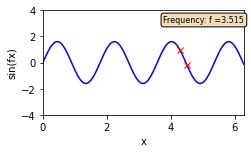

In [8]:
fig = plt.figure(figsize=(9, 5))
plt.subplots_adjust(hspace=0.6, wspace=0.5)

ax = plt.subplot(2, 2, 1)

plt.plot(x_sample, y_in[12355],'b') # Input 0 - 2 pi
plt.plot(x_meas[12355], y_out[12355], 'rx')
plt.xlabel('x');
plt.ylabel('sin(fx)');
plt.xlim([0, 2*np.pi]);
plt.ylim([-4, 4]);

# Print frequency in text box
textstr = r'Frequency: f =%.3f' % (f_0[12355])
props = dict(boxstyle='round', facecolor='wheat', alpha=1)
ax.text(0.60, 0.95, textstr, transform=ax.transAxes, fontsize=8,
verticalalignment='top', bbox = props);

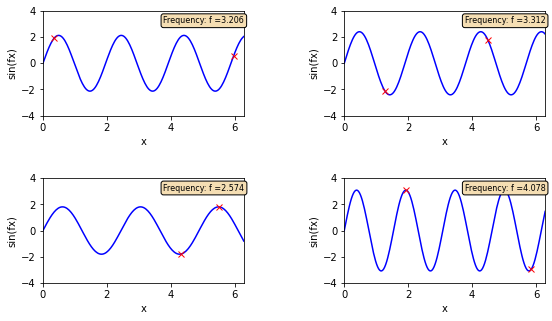

In [9]:
# Plot training data after split
def plot_training_data_split(sample_idx_list):

  fig = plt.figure(figsize=(9, 5))
  plt.subplots_adjust(hspace=0.6, wspace=0.5)

  for i, sample_idx in enumerate(sample_idx_list):
    ax = plt.subplot(2, 2, i+1)
    
    plt.plot(x_sample, y_in_split['test'][sample_idx[0]][sample_idx[1]],'b') # Input 0 - 2 pi
    plt.plot(x_meas_split['test'][sample_idx[0]][sample_idx[1]], y_out_split['test'][sample_idx[0]][sample_idx[1]], 'rx')
    plt.xlabel('x');
    plt.ylabel('sin(fx)');
    plt.xlim([0, 2*np.pi]);
    plt.ylim([-4, 4])

    # Print frequency in text box
    textstr = r'Frequency: f =%.3f' % (f_split['test'][sample_idx[0]][sample_idx[1]])
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.60, 0.95, textstr, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', bbox = props)
    
sample_idx_list = [(0, 92), (0, 93), (0, 94), (0, 95)]
plot_training_data_split(sample_idx_list)

## Training network

In [ ]:
# We train the VAE using the data y_train, f_train etc. defined above

import matplotlib
import pandas as pd
matplotlib.use('Agg') # so it does not show
plt.style.use('default')

def init_training_data(path_exp):
  df = pd.DataFrame(columns=["BETA", 
                           "Total loss", "Reconstruction (MSE)", "KL div", 
                           "Test MAE",
                           "Epochs", "Training time", "Activation", "Batch size",
                           "Saved as", "Seed", "Output nodes"])
  df.to_csv(path + "gifs/" + path_exp + "Training results.csv")

# Parameters to change
OUTPUT_NODES_LIST = [50]
experiment_path = "x output nodes 2pi batch 250 100000 samples 235 random hyperparameters/"
epochs = 600
save_epochs = [30, 60, 90, 120, 300]
save_epochs = []
plot_step = 10
latent_dim = 10
beta = 0.01
seed = 0

for i, OUTPUT_NODES in enumerate(OUTPUT_NODES_LIST):

  # Make data
  x_meas, y_out = make_data(OUTPUT_NODES=OUTPUT_NODES)

  # Split data
  f_split, A_split, y_in_split, x_meas_split, y_out_split = split_data(OUTPUT_NODES=OUTPUT_NODES)

  # Make VAE
  input2_nodes = OUTPUT_NODES
  model = BVAE(latent_dim=latent_dim, beta=beta, 
               input2_nodes=input2_nodes, output_nodes=OUTPUT_NODES,
               seed=seed)
  model.encoder.summary()
  model.decoder.summary()

  # Train VAE
  rows = model.train(epochs=epochs, plot_step=plot_step, save_epochs=save_epochs, experiment_path=experiment_path,
                    y_in_train=y_in_split['train'], y_in_val=y_in_split['val'], y_in_test=y_in_split['test'],
                    y_out_train=y_out_split['train'], y_out_val=y_out_split['val'], y_out_test=y_out_split['test'],
                    x_meas_train=x_meas_split['train'], x_meas_val=x_meas_split['val'], x_meas_test=x_meas_split['test'])
    
  # Save training metadata
  df = pd.read_csv(path + "gifs/" + experiment_path + "Training results.csv", index_col=0)
  for row in rows:
    df = df.append(row, ignore_index=True)
  df.to_csv(path + "gifs/" + experiment_path + "Training results.csv")

  # Save gif
  make_gif(savename = experiment_path + f"output_nodes={OUTPUT_NODES}_BETA={beta}.gif", 
           epochs=epochs, plot_step=plot_step)

Epoch 600 saved
Total training took 87 mins 46 seconds




# Evaluation

## Using training metadata

In [11]:
import pandas as pd
# Load training metadata
experiment_path = "x output nodes 2pi batch 250 100000 samples 235 random 0.005/"
metadata = pd.read_csv(path + "gifs/" + experiment_path + "Training results.csv", index_col=0)
metadata#.sort_values(by=['Output nodes', 'Epochs']).reset_index().drop(columns=['index']).to_csv(path + "gifs/" + experiment_path + "Training results.csv")

,BETA,Total loss,Reconstruction (MSE),KL div,Test MAE,Epochs,Training time,Activation,Batch size,Saved as,Seed,Output nodes
0,0.005,0.124176,0.032905,18.254150,0.130067,30,1 mins 35s,swish,100,BETA=0.005_epochs=30_seed=0_output_nodes=1.hdf5,0,1
1,0.005,0.093831,0.023102,14.145754,0.093704,60,3 mins 10s,swish,100,BETA=0.005_epochs=60_seed=0_output_nodes=1.hdf5,0,1
2,0.005,0.073371,0.010612,12.551790,0.066897,90,4 mins 43s,swish,100,BETA=0.005_epochs=90_seed=0_output_nodes=1.hdf5,0,1
3,0.005,0.066098,0.016525,9.914729,0.086357,120,6 mins 16s,swish,100,BETA=0.005_epochs=120_seed=0_output_nodes=1.hdf5,0,1
4,0.005,0.042809,0.009708,6.620207,0.083809,300,15 mins 34s,swish,100,BETA=0.005_epochs=300_seed=0_output_nodes=1.hdf5,0,1
5,0.005,0.039552,0.006661,6.578105,0.062291,600,31 mins 12s,swish,100,BETA=0.005_epochs=600_seed=0_output_nodes=1.hdf5,0,1
6,0.005,0.136778,0.045217,18.312317,0.127307,30,1 mins 36s,swish,100,BETA=0.005_epochs=30_seed=0_output_nodes=2.hdf5,0,2
7,0.005,0.081248,0.019032,12.443160,0.099369,60,3 mins 11s,swish,100,BETA=0.005_epochs=60_seed=0_output_nodes=2.hdf5,0,2
8,0.005,0.061090,0.012054,9.807207,0.088478,90,4 mins 45s,swish,100,BETA=0.005_epochs=90_seed=0_output_nodes=2.hdf5,0,2
9,0.005,0.064197,0.014446,9.950259,0.087219,120,6 mins 20s,swish,100,BETA=0.005_epochs=120_seed=0_output_nodes=2.hdf5,0,2


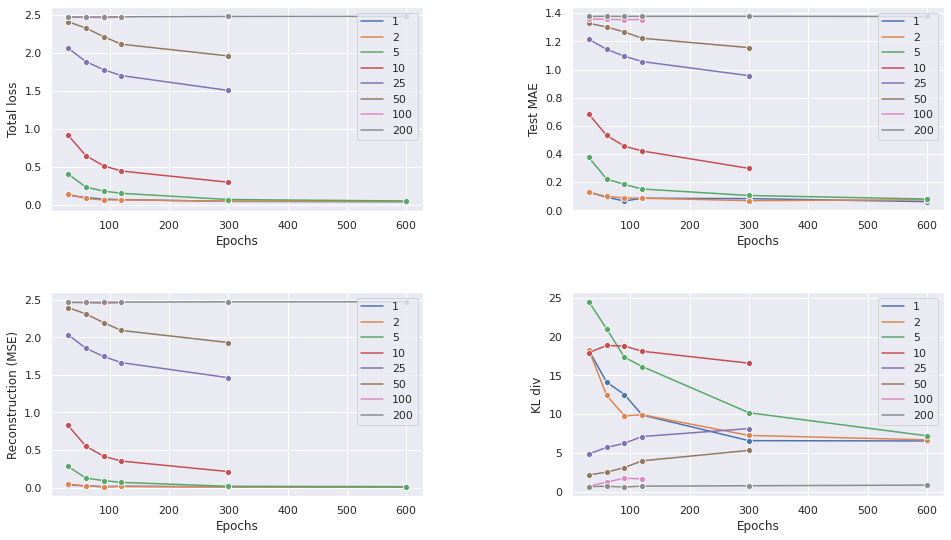

In [ ]:
import seaborn as sns
sns.set_theme()

# Get right models to plot
partdata = metadata
metrics = ['Total loss', 'Test MAE', 'Reconstruction (MSE)', 'KL div']

# Plot 4 metrics in function of BETA
fig, axs = plt.subplots(2, 2, figsize=(16, 9))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i, metric in enumerate(metrics):
  ax = axs.reshape(-1)[i]
  sns.lineplot(x='Epochs', y=metric, hue='Output nodes', 
               data=partdata, ax=ax, palette='deep', marker='o')
  ax.legend(fontsize=11, loc='upper right')

## Reconstructing spectra

In [13]:
# Get model from pandas row
def get_model(row, experiment_path):
  beta = row['BETA']
  output_nodes = row['Output nodes']
  model = BVAE(latent_dim=10, beta=beta, 
               input2_nodes=output_nodes, output_nodes=output_nodes)
  
  model.encoder = tf.keras.models.load_model(path + "encoders/" + experiment_path + 
                                             row['Saved as'],
                                             compile=False)
  model.decoder = tf.keras.models.load_model(path + f"decoders/" + experiment_path + 
                                             row['Saved as'],
                                             compile=False)
  specs = {"epochs": row['Epochs'], 
           "seed": row['Seed'], 
           "MAE": row['Test MAE'],
           "output nodes": output_nodes}
  return model, specs

We have 100000 samples: 
First frequency is 3.0269151102110445 and last frequency is 2.1869652260768753 

We have 90000 training samples and 10000 test samples

We have 40 test batches with 250 sine functions each
MAE on the test set: nan 



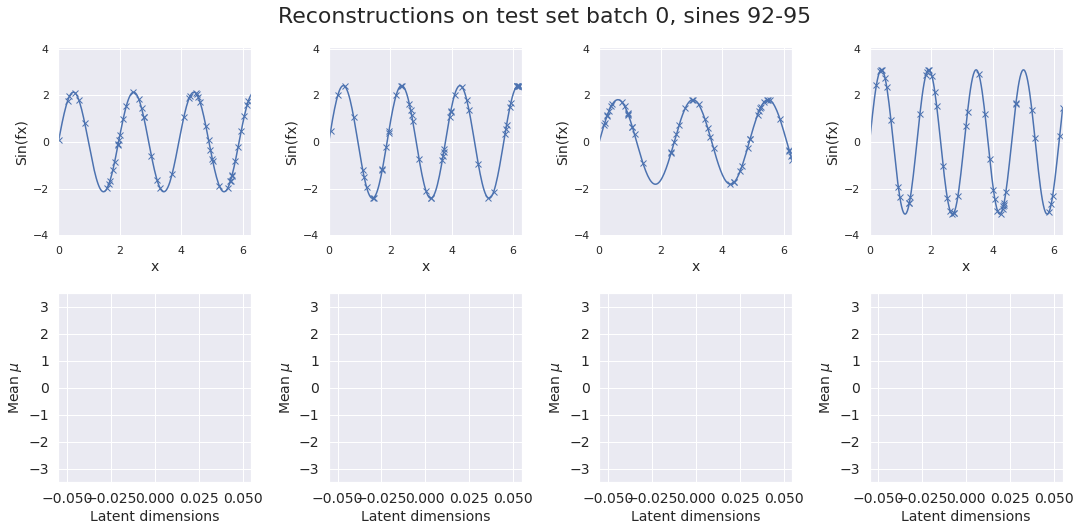

In [ ]:
# Show reconstruction
def reconstruct(model, specs, y_in_test, x_meas_test):
  "Get reconstruction of 10000 samples in test set"
  x_0 = np.linspace(0, 2*np.pi, 200)
 
  mean, logvar = model.encode(y_in_test.reshape(-1, 200))
  z_test = model.reparameterize(mean, logvar)
  answer = model.decode(tf.concat([z_test, x_meas_test.reshape(-1, specs['output nodes'])], axis=1))
    
  reconstruction = {
      "mean" : mean, "logvar" : logvar, 
      "z_test" : z_test, "answer" : answer
  }
  return reconstruction

def show_reconstruction(y_test, reconstruction, n, batch = 0, start=0):
  plt.figure(figsize = (18, 8 * np.ceil(n/4)))
  plt.suptitle(f"Reconstructions on test set batch {batch}, sines {start}-{start+n-1}", y=0.95, fontsize=22)

  x = np.linspace(0, 2*np.pi, 200)

  for i in range(n):
      # idx in test samples up to 10000
      linear_idx = i + start + (batch*BATCH_SIZE)

      # Plot reconstruction
      plt.subplot(2*np.ceil(n/4), 4, i + 1 + 4*np.floor(i/4))

      # ground truth
      plt.plot(x, y_test[batch][i + start]) # Input 0 - 2 pi
      plt.plot(x_meas_split['test'][batch][i + start], y_out_split['test'][batch][i + start], 'bx') # Output ground truth

      # reconstruction
      plt.plot(x_meas_split['test'][batch][i + start], reconstruction['answer'][linear_idx], 'rx') # Output reconstruction
      plt.xlabel("x", fontsize=14)
      plt.ylabel("Sin(fx)", fontsize=14)
      plt.ylim([-4.05, 4.05])
      plt.xlim([0, 2*np.pi])

      # Plot latent dimensions
      plt.subplot(2*np.ceil(n/4), 4, i + 1 + 4 + 4*np.floor(i/4))
      latent_dim = len(reconstruction['mean'][0])
      std = np.exp(reconstruction['logvar'][linear_idx].numpy() * .5).reshape(latent_dim)
      plt.errorbar(range(1, latent_dim + 1), reconstruction['mean'][linear_idx], 
                   yerr=std, marker=".", ls=" ", capsize=5)
      plt.plot(range(1, latent_dim + 1), reconstruction['z_test'][linear_idx], 'r.')
      plt.xlabel("Latent dimensions", fontsize=14)
      plt.ylabel("Mean $\mu$", fontsize=14)
      plt.ylim([-3.5, 3.5])
      plt.xticks(fontsize=14)
      plt.yticks(fontsize=14)
  plt.subplots_adjust(wspace=0.4, hspace=0.3)

#mean and logvar are the same every time we run
#z is random and different every time we run

BATCH_SIZE = y_in_split['test'].shape[1]

# we get the model and reconstruct all test spectra using y_in_test
model, specs = get_model(metadata.loc[35], experiment_path="x output nodes 2pi batch 250 100000 samples 235 random 0.01/")

OUTPUT_NODES = model.input2_nodes
x_meas, y_out = make_data(OUTPUT_NODES=OUTPUT_NODES)
f_split, A_split, y_in_split, x_meas_split, y_out_split = split_data(OUTPUT_NODES=OUTPUT_NODES)

reconstruction = reconstruct(model, specs, y_in_split['test'], x_meas_split['test'])

# we show batch 0, samples 92-95
show_reconstruction(y_in_split['test'], reconstruction, n = 4, batch = 0, start=92)

print(f"We have {y_in_split['test'].shape[0]} test batches with {y_in_split['test'].shape[1]} sine functions each")
print(f"MAE on the test set: {specs['MAE']:.03f} \n")

## KL divergence per dimension

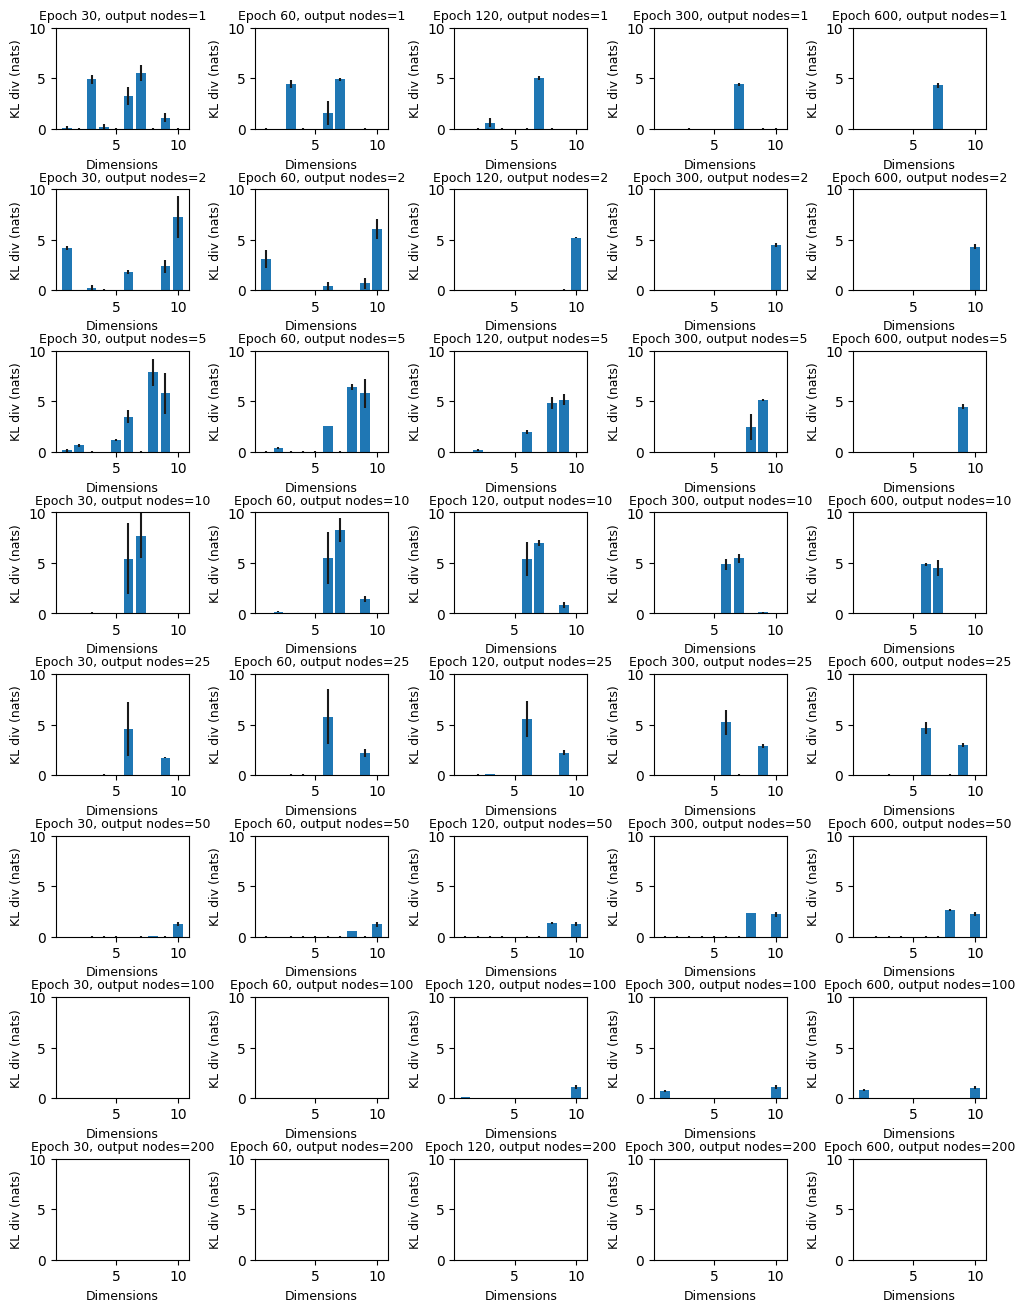

In [ ]:
def log_normal_pdf_per_dimension(sample, mean, logvar, raxis=1):
  "Returns mean and std per dimension, example shape (10, 2)"
  log2pi = tf.math.log(2. * np.pi)
  mean_log_normal = tf.reduce_mean(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=0)
  std_log_normal = tf.math.reduce_std(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=0)
  log_normal = tf.stack([mean_log_normal, std_log_normal], axis=1)
  return log_normal
    
def kl_divergence_per_dimension(model, specs, ax, i):
  # Forward pass
  mean, logvar = model.encode(y_in_test.reshape(-1, 200))
  z = model.reparameterize(mean, logvar)
    
  # Compute KL
  logpz = log_normal_pdf_per_dimension(z, 0., 0.) #0 is logvar of 1 
  logqz_x = log_normal_pdf_per_dimension(z, mean, logvar)
  kl_divergence = logqz_x - logpz 
  kl_mean = kl_divergence[:, 0]
  kl_std = kl_divergence[:, 1]

  # Plot KL
  ax.bar(np.arange(1, len(kl_mean)+1), kl_mean, yerr=kl_std)
  ax.set_ylabel("KL div (nats)", fontsize=9)
  ax.set_xlabel("Dimensions", fontsize=9)
  #ax.set_title(f"Model {i}", fontsize=9)
  epoch_list = [30, 300, 600]
  ax.set_title(f"Epoch {specs['epochs']}, output nodes={specs['output nodes']}", fontsize=9)
  ax.set_ylim(0, 10)

  textstr = r'$\beta$=%.4f' % (model.beta)
  props = dict(boxstyle='round', facecolor='wheat', alpha=1)
  #ax.text(0.60, 0.95, textstr, transform=ax.transAxes, fontsize=8,
          #verticalalignment='top', bbox = props)

model_idx = [0, 1, 3, 4, 5,
             6, 7, 9, 10, 11,
             12, 13, 15, 16, 17,
             18, 19, 21, 22, 23,
             24, 25, 27, 28, 29, 
             30, 31, 33, 34, 35, 
             36, 37, 39, 40, 41, 
             42, 43, 45, 46, 47]
subplot_idx = [0, 1, 2, 3, 4,
               5, 6, 7, 8, 9,
               10, 11, 12, 13, 14,
               15, 16, 17, 18, 19,
               20, 21, 22, 23, 24,
               25, 26, 27, 28, 29,
               30, 31, 32, 33, 34,
               35, 36, 37, 38, 39]

plt.style.use('default')
fig, axs = plt.subplots(8, 5, figsize=(12, 16))
plt.subplots_adjust(hspace=0.6, wspace=0.5)

for ax_i, i in zip(subplot_idx, model_idx):
  model, specs = get_model(metadata.iloc[i], 
                           experiment_path="x output nodes 2pi batch 250 100000 samples 235 random/")
  kl_divergence_per_dimension(model, specs, ax=axs.reshape(-1)[ax_i], i=i)

## Active Units (AU) and simplifying table

In [ ]:
def get_active_units(panda_row, experiment_path, verbose):
  """Calculates active units in the latent space"""
  model, specs = get_model(panda_row, experiment_path)

  # Select train or test data
  mean, _ = model.encode(y_in_split['test'].reshape(-1, 200))
  f = f_split['test'].reshape(-1)

  # Compute Activated Units (AU) using cov(mu)
  active_units = 0
  treshold = 0.005
  for i in range(10):
    cov_mu = np.cov(mean[:, i])
    if cov_mu > treshold:
      print(f"Latent dimension {i+1} is active!") if verbose else ''
      active_units += 1
  print(f"There are {active_units} active latent dimensions!") if verbose else ''
  
  return active_units

units = get_active_units(metadata.loc[34], 
                         experiment_path="x output nodes 2pi batch 250 100000 samples 235 random 0.01/",
                         verbose=False)

In [ ]:
# Create active units series from metadata (for epochs==600)
from functools import partial 
partdata = metadata.iloc[[23, 29, 33, 41, 47]]
active_units = partdata.apply(partial(get_active_units, 
                       experiment_path="x output nodes 2pi batch 250 100000 samples 235 random 0.01/",
                       verbose=False), axis=1)

In [ ]:
# Create simplifying table for overleaf
simple_table = metadata[['Output nodes', 'Test MAE', 'KL div']].iloc[[23, 29, 33, 41, 47]].copy()
simple_table['Active Units'] = active_units
simple_table
#simple_table.to_latex(index=False)

,Output nodes,Test MAE,KL div,Active Units
23,10,0.287683,9.877740,3
29,25,1.145263,5.223436,3
33,50,1.214753,3.278734,3
41,100,1.345140,0.002214,0
47,200,1.381057,0.002029,0


## Correlation with A and f

Latent dimension 1 is active!
Latent dimension 6 is active!
There are 2 active latent dimensions!


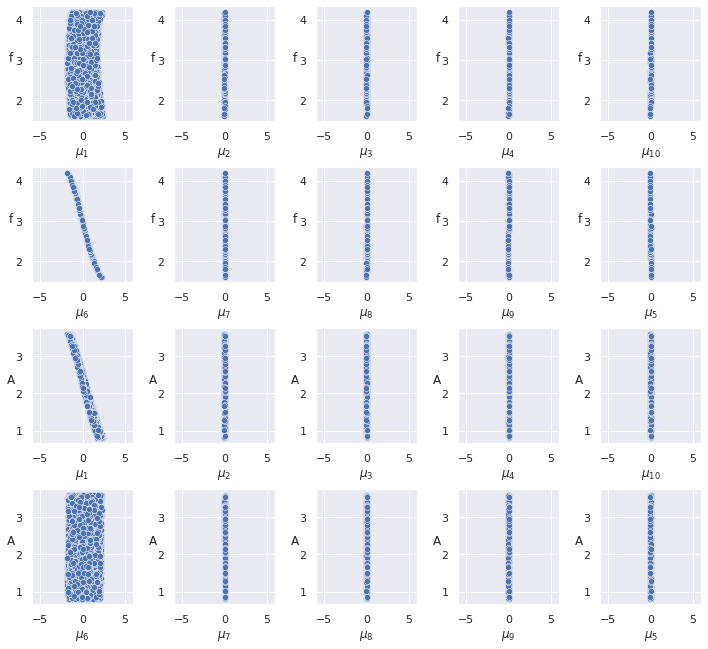

In [15]:
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
from scipy.stats import spearmanr, pearsonr

def plot_correlation(model, mode='test'):
  """Creates a scatter plot between f and the mean of each dimension. Also 
  computes the spearman correlation between f and each of the dimensions."""
  # Select train or test data
  if mode == 'test':  
    mean, _ = model.encode(y_in_split['test'].reshape(-1, 200))
    f = f_split['test'].reshape(-1)
    A = A_split['test'].reshape(-1)
  elif mode == 'train':
    mean, _ = model.encode(Y_in_train.reshape(-1, 200))
    f = f_split['train'].reshape(-1)
    A = A_split['train'].reshape(-1)
  else:
    print("Error: only accepts modes train and test")
    return

  # Create scatterplots
  fig, axs = plt.subplots(4, 5, figsize=(12, 11))
  plt.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(10):
    ax_idx = [0, 1, 2, 3, 9, 5, 6, 7, 8, 4]
    ax = axs.reshape(-1)[ax_idx[i]]
    sns.scatterplot(x=mean[:, i], y=f, palette="RdBu",  ax=ax)
    ax.set_xlim([-6, 6])

    # To get 10 in underscore
    if (i + 1) != 10:
      ax.set_xlabel(f"$\mu_{i+1}$")
    elif (i+1) == 10:
      ax.set_xlabel(r"$\mu_{10}$")

    ax.set_ylabel("f", rotation='horizontal')

  for i in range(10):
    ax_idx = [0, 1, 2, 3, 9, 5, 6, 7, 8, 4]
    ax = axs.reshape(-1)[ax_idx[i] + 10]
    sns.scatterplot(x=mean[:, i], y=A, palette="RdBu",  ax=ax)
    ax.set_xlim([-6, 6])

    # To get 10 in underscore
    if (i + 1) != 10:
      ax.set_xlabel(f"$\mu_{i+1}$")
    elif (i+1) == 10:
      ax.set_xlabel(r"$\mu_{10}$")

    ax.set_ylabel("A", rotation='horizontal')

  fig.show()

  # Compute correlation with each dimension
  for i in range(10):
    corr, p = spearmanr(mean[:, i], f)
    #print(f"Spearman correlation dimension {i+1}: {corr:.3f} (p-value {p:.3f})")  
  #print("\n")

  # Compute Activated Units (AU) using cov(mu)
  active_dims = 0
  treshold = 0.01
  for i in range(10):
    cov_mu = np.cov(mean[:, i])
    if cov_mu > treshold:
      print(f"Latent dimension {i+1} is active!")
      active_dims += 1
  print(f"There are {active_dims} active latent dimensions!")

model, specs = get_model(metadata.loc[11], experiment_path="x output nodes 2pi batch 250 100000 samples 235 random 0.005/")
plot_correlation(model, mode='test')

f shape: (10000,)
A shape: (10000,)
mean shape: (10000, 10)
correlation shape: (10000, 12)
Latent dimension 6 is active!
Latent dimension 7 is active!
Latent dimension 9 is active!
There are 3 active latent dimensions!
f shape: (10000,)
A shape: (10000,)
mean shape: (10000, 10)
correlation shape: (10000, 12)
Latent dimension 3 is active!
Latent dimension 6 is active!
Latent dimension 9 is active!
There are 3 active latent dimensions!
f shape: (10000,)
A shape: (10000,)
mean shape: (10000, 10)
correlation shape: (10000, 12)
There are 0 active latent dimensions!
f shape: (10000,)
A shape: (10000,)
mean shape: (10000, 10)
correlation shape: (10000, 12)
There are 0 active latent dimensions!


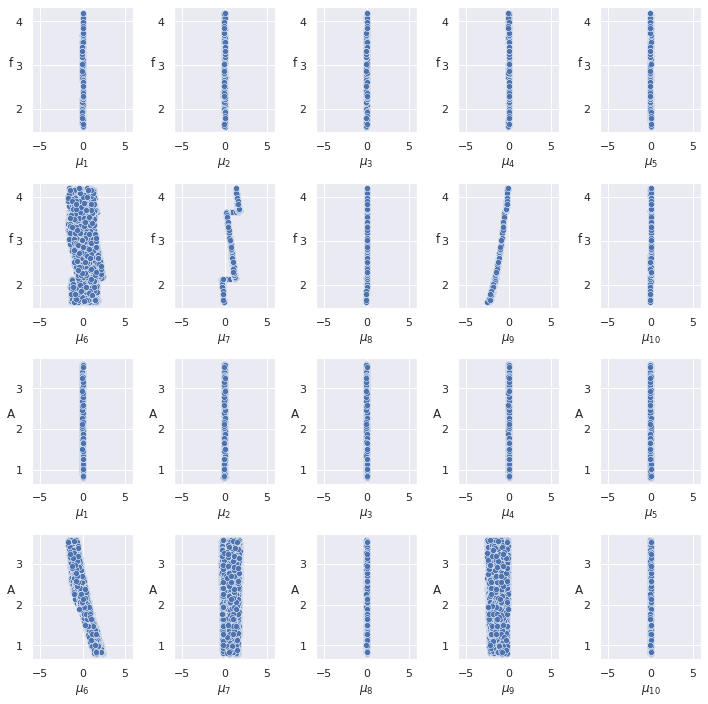

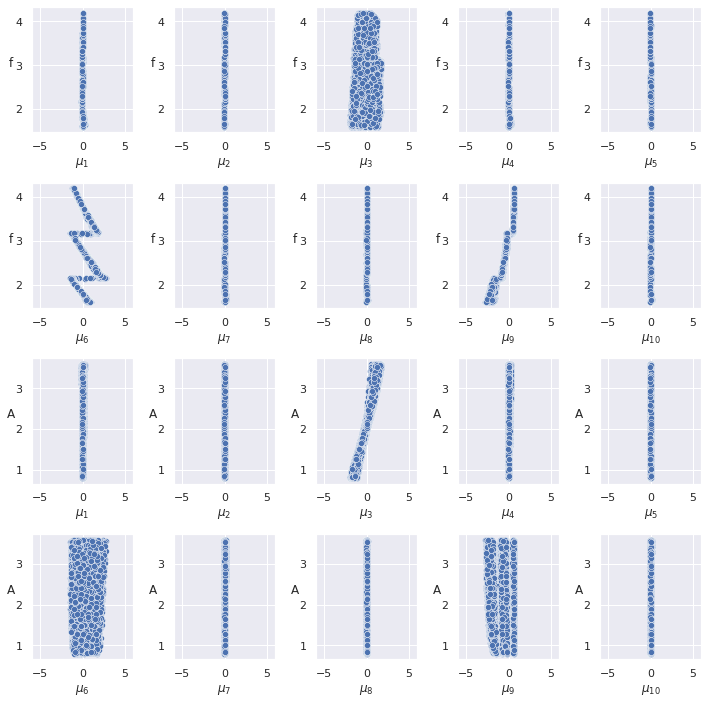

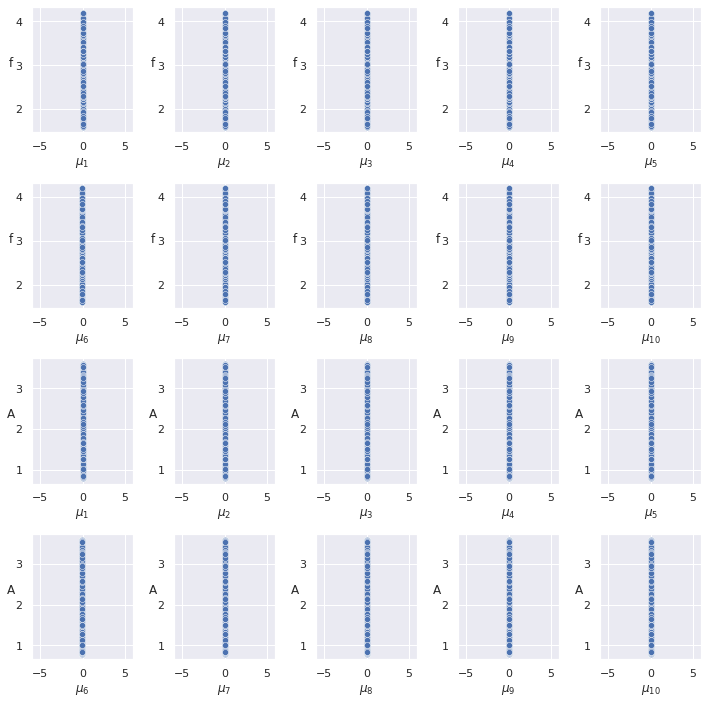

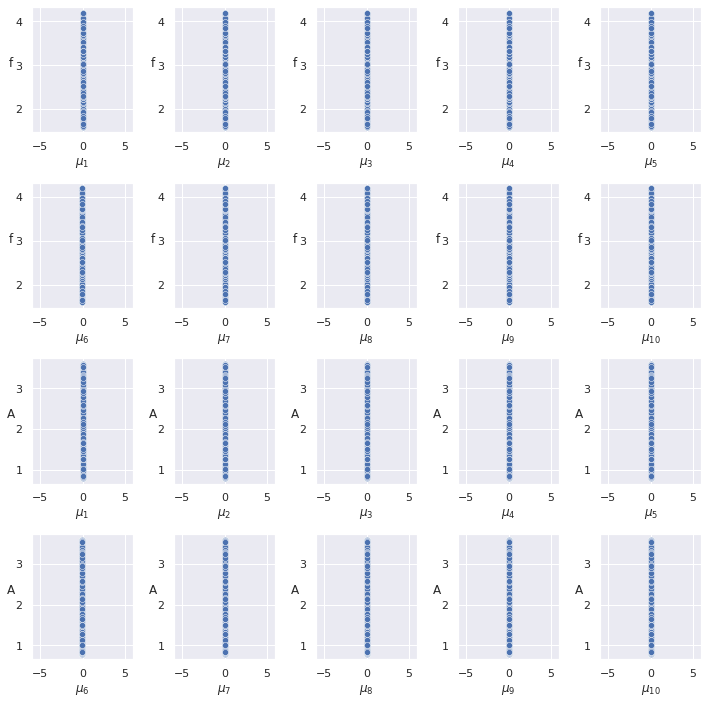

In [ ]:
# Save correlations for figures
def save_correlation(model, specs, experiment_path):
  """Creates a scatter plot between f and the mean of each dimension. Also 
  computes the spearman correlation between f and each of the dimensions."""
  # Select train or test data
  mean, _ = model.encode(y_in_split['test'].reshape(-1, 200))
  f = f_split['test'].reshape(-1)
  A = A_split['test'].reshape(-1)
  
  # Save correlation
  print(f"f shape: {f.shape}")
  print(f"A shape: {A.shape}")
  print(f"mean shape: {mean.shape}")
  correlation = np.concatenate([f.reshape(-1, 1), A.reshape(-1, 1), mean], axis=1)
  print(f"correlation shape: {correlation.shape}")
  np.save(path + "gifs/" + experiment_path + f"correlation_random_output_nodes={specs['output nodes']}",
          correlation)

  # Create scatterplots
  fig, axs = plt.subplots(4,5, figsize=(12, 12))
  plt.subplots_adjust(hspace=0.4, wspace=0.4)

  # plots with f
  for i in range(10):
    ax = axs.reshape(-1)[i]
    sns.scatterplot(x=mean[:, i], y=f, palette="RdBu",  ax=ax)
    ax.set_xlim([-6, 6])

    # To get 10 in underscore
    if (i + 1) != 10:
      ax.set_xlabel(f"$\mu_{i+1}$")
    elif (i+1) == 10:
      ax.set_xlabel(r"$\mu_{10}$")

    ax.set_ylabel("f", rotation='horizontal')

  fig.show()

  # plots with A
  for i in range(10):
    ax = axs.reshape(-1)[i+10]
    sns.scatterplot(x=mean[:, i], y=A, palette="RdBu",  ax=ax)
    ax.set_xlim([-6, 6])

    # To get 10 in underscore
    if (i + 1) != 10:
      ax.set_xlabel(f"$\mu_{i+1}$")
    elif (i+1) == 10:
      ax.set_xlabel(r"$\mu_{10}$")

    ax.set_ylabel("A", rotation='horizontal')

  fig.show()

  # Compute Activated Units (AU) using cov(mu)
  active_dims = 0
  treshold = 0.01
  for i in range(10):
    cov_mu = np.cov(mean[:, i])
    if cov_mu > treshold:
      print(f"Latent dimension {i+1} is active!")
      active_dims += 1
  print(f"There are {active_dims} active latent dimensions!")

"""for model_idx in [5, 11, 17]:
  model, specs = get_model(metadata.loc[model_idx], experiment_path="x output nodes 2pi batch 250 100000 samples 235 random 0.005/")
  save_correlation(model, specs, experiment_path="x output nodes 2pi batch 250 100000 samples 235 random 0.005/")"""

for model_idx in [23, 29, 41, 47]:
  model, specs = get_model(metadata.loc[model_idx], experiment_path="x output nodes 2pi batch 250 100000 samples 235 random 0.01/")
  save_correlation(model, specs, experiment_path="x output nodes 2pi batch 250 100000 samples 235 random 0.01/")

Pearson corr dimension 1 and T: 0.006 (p-value 0.577)
Pearson corr dimension 2 and T: -0.882 (p-value 0.000)
Pearson corr dimension 3 and T: -0.913 (p-value 0.000)
Pearson corr dimension 4 and T: 0.001 (p-value 0.958)
Pearson corr dimension 5 and T: -0.106 (p-value 0.000)
Pearson corr dimension 6 and T: -0.960 (p-value 0.000)
Pearson corr dimension 7 and T: 0.973 (p-value 0.000)
Pearson corr dimension 8 and T: 0.746 (p-value 0.000)
Pearson corr dimension 9 and T: 0.600 (p-value 0.000)
Pearson corr dimension 10 and T: 0.955 (p-value 0.000)


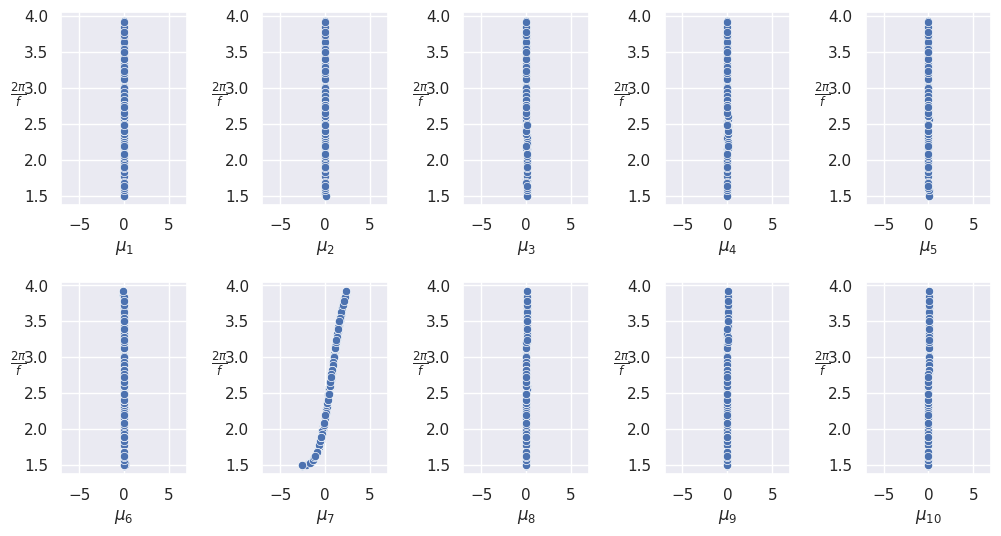

In [ ]:
def plot_correlation_inverse(model, mode='test'):
  """Creates a scatter plot between f and the mean of each dimension. Also 
  computes the spearman correlation between f and each of the dimensions."""
  # Select train or test data
  if mode == 'test':  
    mean, _ = model.encode(y_in_test.reshape(-1, 200))
    f = f_test.reshape(-1)
  elif mode == 'train':
    mean, _ = model.encode(Y_in_train.reshape(-1, 200))
    f = f_train.reshape(-1)
  else:
    print("Error: only accepts modes train and test")
    return

  # Create scatterplots
  fig, axs = plt.subplots(2,5, figsize=(12, 6))
  plt.subplots_adjust(hspace=0.4, wspace=0.6)

  for i in range(10):
    ax = axs.reshape(-1)[i]
    sns.scatterplot(x=mean[:, i], y=2*np.pi/f, palette="RdBu",  ax=ax)
    ax.set_xlim([-7, 7])

    # To get 10 in underscore
    if (i + 1) != 10:
      ax.set_xlabel(f"$\mu_{i+1}$")
    elif (i+1) == 10:
      ax.set_xlabel(r"$\mu_{10}$")
    ax.set_ylabel(r"$\frac{2 \pi}{f}$", rotation='horizontal')

  fig.show()

  # Compute correlation with each dimension
  for i in range(10):
    corr, p = pearsonr(mean[:, i], 2*np.pi/f)
    print(f"Pearson corr dimension {i+1} and T: {corr:.3f} (p-value {p:.3f})")  

model, specs = get_model(metadata.loc[5], experiment_path="1 output node 2pi batch 250 100000 samples 235/")
plot_correlation_inverse(model, mode='test')

Shape mu: (100000,)


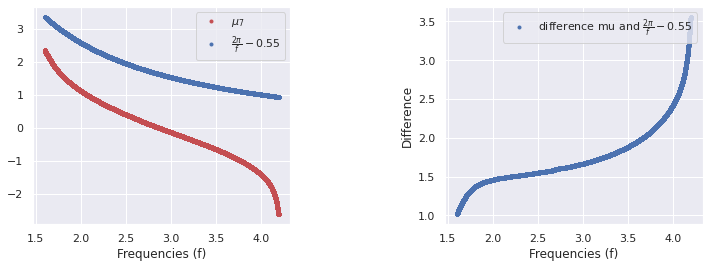

In [ ]:
# Compare 2pi/f and mu

%matplotlib inline 
# to fix error

def plot_difference_mu_T(model):
  """Plots the difference between mu and 2pi/f for a given model"""

  # Compute on full data set
  mean, _ = model.encode(y_in)
  f = f_0

  fig = plt.figure(figsize=(12, 4))
  plt.subplots_adjust(hspace=0.4, wspace=0.6)

  c = 1
  # Plot mu and 2pi/f 
  ax = plt.subplot(1, 2, 1)
  mu = mean[:, 7-1]
  print(f"Shape mu: {mu.shape}")
  plt.plot(f_0, mu, 'r.', label=r'$\mu_{7}$')
  plt.plot(f_0, 2*np.pi/f-0.555806842220, 'b.', label=r'$\frac{2\pi}{f}-0.55$')
  #plt.plot(f_0, 6.27*np.sin(np.sin((np.log(f_0)+1)))/f_0, 'g', label='sin(sin(log(f)+1)))/f') # formule van AI Feynman
  #plt.ylabel('Period T (s)')
  plt.xlabel('Frequencies (f)')
  plt.legend(loc='upper right')

  # Plot difference between mu and 2pi/f
  ax = plt.subplot(1, 2, 2)
  plt.plot(f_0, (c*2*np.pi/f_0-0.555806842220) - mu, 'b.', label=r'difference mu and $\frac{2\pi}{f}-0.55$')
  plt.ylabel('Difference')
  plt.xlabel('Frequencies (f)')
  plt.legend(loc='upper right')

  fig.show()

model, specs = get_model(metadata.loc[5], experiment_path="1 output node 2pi batch 250 100000 samples 235/")
plot_difference_mu_T(model)

## Latent space

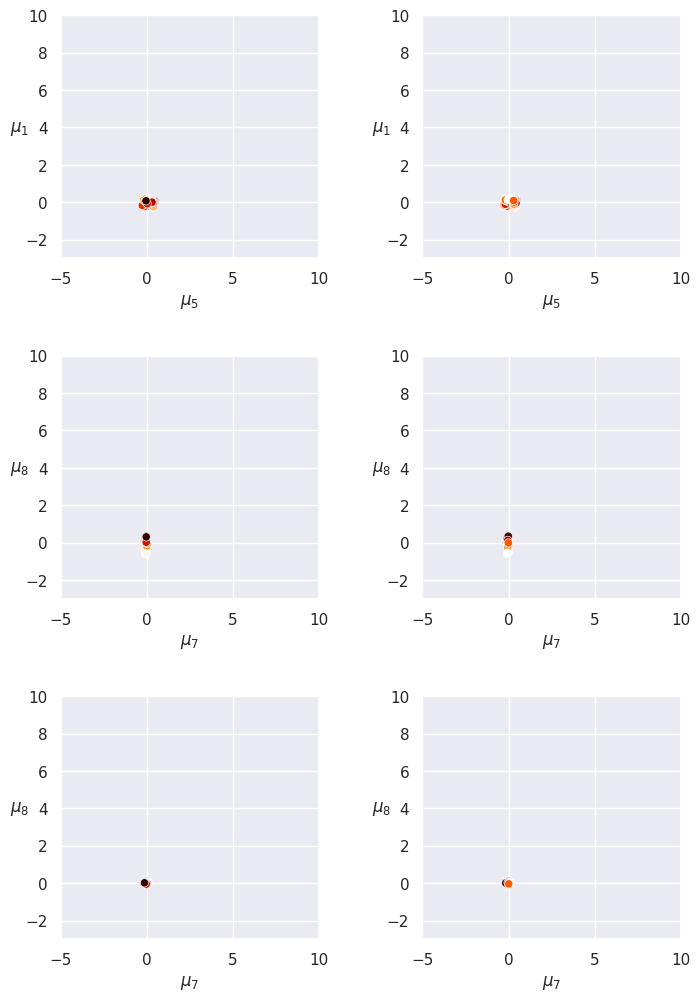

In [ ]:
# 2D latent space plot
def plot_latent_2d(model, dim1, dim2, mode='test', ax=ax):
  """Creates a 2D plot of latens dimensions dim1 and dim2."""
  # Select train or test data
  if mode == 'test':  
    mean, _ = model.encode(y_in_test.reshape(-1, 200))
    f = f_test.reshape(-1)
  elif mode == 'train':
    mean, _ = model.encode(y_in_train.reshape(-1, 200))
    f = f_train.reshape(-1)
  else:
    print("Error: only accepts modes train and test")
    return

  # Create scatterplots
  sns.scatterplot(x=mean[:, dim1-1], y=mean[:, dim2-1], c=f, cmap="gist_heat",  ax=ax) #RdBu
  ax.set_xlim([-5, 10])
  ax.set_ylim([-3, 10])
  ax.set_xlabel(f"$\mu_{dim1}$")
  ax.set_ylabel(f"$\mu_{dim2}$", rotation='horizontal')

fig, axs = plt.subplots(3, 2, figsize=(8, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

model, specs = get_model(metadata.loc[2], experiment_path="1 output node with seed 6pi/")
plot_latent_2d(model, dim1=5, dim2=1, mode='test', ax=axs[0][0])
plot_latent_2d(model, dim1=5, dim2=1, mode='train', ax=axs[0][1])

model, specs = get_model(metadata.loc[6], experiment_path="1 output node with seed 6pi/")
plot_latent_2d(model, dim1=7, dim2=8, mode='test', ax=axs[1][0])
plot_latent_2d(model, dim1=7, dim2=8, mode='train', ax=axs[1][1])

model, specs = get_model(metadata.loc[8], experiment_path="1 output node with seed 6pi/")
plot_latent_2d(model, dim1=7, dim2=8, mode='test', ax=axs[2][0])
plot_latent_2d(model, dim1=7, dim2=8, mode='train', ax=axs[2][1])

fig.show()

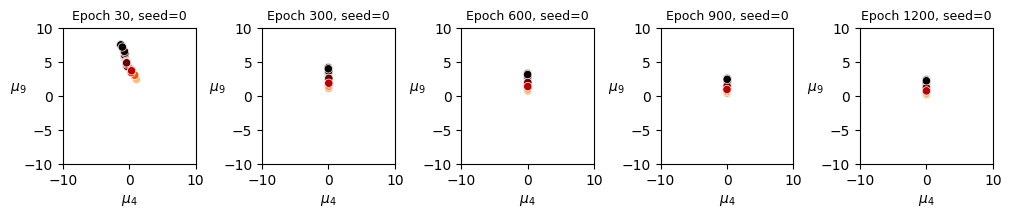

In [ ]:
# 2D+3D latent space plot with seeds
def plot_latent_2d(model, specs, dims, mode='test', ax=ax):
  """Creates a 2D plot of latent dimensions dim1 and dim2."""
  # Select train or test data
  if mode == 'test':  
    mean, _ = model.encode(y_in_test.reshape(-1, 200))
    f = f_test.reshape(-1)
  elif mode == 'train':
    mean, _ = model.encode(y_in_train.reshape(-1, 200))
    f = f_train.reshape(-1)
  else:
    print("Error: only accepts modes train and test")
    return

  # Set title
  ax.set_title(f"Epoch {specs['epochs']}, seed={specs['seed']}", fontsize=9)

  # 2d plot
  if len(dims) == 2:
    dim1, dim2 = dims
    
    # Create scatterplots
    sns.scatterplot(x=mean[:, dim1-1], y=mean[:, dim2-1], c=f, cmap="gist_heat",  ax=ax) #RdBu
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_xlabel(f"$\mu_{dim1}$")
    if dim2 == 10:
      ax.set_ylabel(r"$\mu_{10}$", rotation='horizontal')
    else:
      ax.set_ylabel(f"$\mu_{dim2}$", rotation='horizontal')

  # 3d plot
  elif len(dims) == 3:
    dim1, dim2, dim3 = dims
    # Create scatterplots
    ax.scatter(xs=mean[:, dim1-1], ys=mean[:, dim2-1], zs=mean[:, dim3-1], c=f, cmap="gist_heat")
    ax.set_xlim([0, 8])
    ax.set_ylim([-1, 6])
    ax.set_zlim([-8, 1])
    ax.set_xlabel(f'$\mu_{dim1}$')
    ax.set_ylabel(f"$\mu_{dim2}$", rotation='horizontal')
    ax.set_zlabel(f"$\mu_{dim3}$", rotation='horizontal')

model_idx = [0, 2, 3, 4, 5]
subplot_idx = [0, 1, 2, 3, 4]

# Latent dimensions to plot            
dims = [(4, 9), (4, 9), (4, 9), (4, 9), (4, 9)]

plt.style.use('default')
fig = plt.figure(figsize=(12, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, model_i in enumerate(model_idx):
  
  ax_i = subplot_idx[i]
  dims_i = dims[i]

  # Pick 2d or 3d ax
  if len(dims_i) == 2:
    ax = fig.add_subplot(6, 5, ax_i+1)
  elif len(dims_i) == 3:
    ax = fig.add_subplot(6, 5, ax_i+1, projection='3d')

  model, specs = get_model(metadata.iloc[model_i], experiment_path="1 output node 4pi batch 250 100000 samples 235/")
  plot_latent_2d(model, specs,
                 dims_i, mode='test', ax=ax)

## Reconstruct full sine wave

In [ ]:
# Show reconstruction
def reconstruct(model, y_in_batch, x_meas_batch):
  "Get reconstruction for given batch"
  answer = []
  
  x_0 = np.linspace(0, 2*np.pi, 200)
 
  mean, logvar = model.encode(y_in_batch.reshape(-1, 200))
  z_test = model.reparameterize(mean, logvar)
  for x in np.linspace(0, 2*np.pi, 200):
    x_batch = np.array([x for y_in in y_in_batch]) 
    answer_for_x = model.decode(tf.concat([z_test, x_batch.reshape(-1, 1)], axis=1))
    answer.append(answer_for_x)
  answer = np.array(answer).reshape(200, 4).T # to get (4, 200)

  single_answer = model.decode(tf.concat([z_test, x_meas_batch.reshape(-1, 1)], axis=1))
  
  reconstruction = {
      "mean" : mean, "logvar" : logvar, 
      "z_test" : z_test, "answer" : answer, 
      "single_answer": single_answer
  }
  return reconstruction

def show_reconstruction(y_in_batch, reconstruction, f_batch, title):
  plt.figure(figsize = (18, 8))
  plt.suptitle(title, y=0.95, fontsize=22)

  x = np.linspace(0, 4*np.pi, 400)
  x_0 = x[:200]

  mae = tf.reduce_mean(tf.keras.losses.mean_absolute_error(y_in_batch, reconstruction['answer'][:, :200]))
  print(f"MAE on batch: {mae:.03f}")

  for i in range(4):
      # Plot reconstruction
      plt.subplot(2, 4, i + 1 + 4*np.floor(i/4))
      plt.plot(x_0, y_in_batch[i], 'b') # Input 0 - 2 pi
      plt.plot(x_meas_batch[i], y_out_batch[i], 'gx')
      plt.plot(x_0, reconstruction['answer'][i][:200], 'r') # Output 0 - 2 pi
      plt.xlabel("x", fontsize=14)
      plt.ylabel("Sin(fx)", fontsize=14)
      plt.ylim([-1.05, 1.05])
      plt.xlim([0, 2*np.pi])

      # Plot latent dimensions
      plt.subplot(2*np.ceil(n/4), 4, i + 1 + 4 + 4*np.floor(i/4))
      latent_dim = len(reconstruction['mean'][0])
      std = np.exp(reconstruction['logvar'][i].numpy() * .5).reshape(latent_dim)
      plt.errorbar(range(1, latent_dim + 1), reconstruction['mean'][i], 
                   yerr=std, marker=".", ls=" ", capsize=5)
      plt.plot(range(1, latent_dim + 1), reconstruction['z_test'][i], 'r.')
      plt.xlabel("Latent dimensions", fontsize=14)
      plt.ylabel("Mean $\mu$", fontsize=14)
      plt.ylim([-3.5, 3.5])
      plt.xticks(fontsize=14)
      plt.yticks(fontsize=14)

  plt.subplots_adjust(wspace=0.4, hspace=0.3)

#mean and logvar are the same every time we run
#z is random and different every time we run

batch = 0
start = 92
n = 4
y_in_batch = y_in_test[batch][start:(start+n)]
f_batch = f_test[batch][start:(start+n)]
x_meas_batch = x_meas_test[batch][start:(start+n)]
y_out_batch = y_out_test[batch][start:(start+n)]

model, specs = get_model(metadata.loc[23], experiment_path="x output nodes 2pi batch 250 100000 samples 235 random/")
reconstruction = reconstruct(model, y_in_batch, x_meas_batch)
show_reconstruction(y_in_batch, reconstruction, f_batch,
                    title=f"Reconstructions on test set batch {batch}, sines {start}-{start+n-1}")

print(f"We have {y_in_test.shape[0]} test batches with {y_in_test.shape[1]} sine functions each")
print(f"MAE on the test set: {specs['MAE']:.03f} \n")

ValueError: ignored

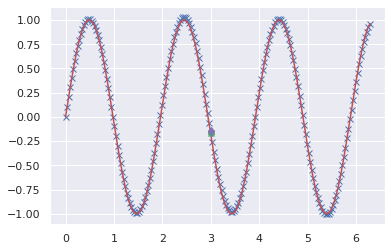

In [ ]:
reconstruction['answer'][0][:200].shape
j = 0 # sample in batch 92-96
x = np.linspace(0, 2*np.pi, 200)
x_0 = x[:200]
plt.plot(x, reconstruction['answer'][j], 'x')
plt.plot(x_0, y_in_batch[j], 'r')
plt.plot(x_meas_batch[j], y_out_batch[j], 'go')
plt.plot(x_meas_batch[j], reconstruction['single_answer'][j], 'md')
#plt.xlim([0, 6*np.pi])x